# Read KYC documents using OCR
## Purpose
Here we are trying to read uploaded image of PAN/Passport/Aadhar to get relevant information regarding the customer and subsequently verify them through API calls to corresponding authority. Once we are sucessful in the venture, we can adopt online account opening with automated KYC verification. 
## Data
Nyoo Cards has provided us an initial simple of 1000 images of PAN and Passport. We have started our development and testing with that data. 

In [54]:

from glob import glob


img_lst = glob('nyoo_images/**/*.jpeg', recursive=True)
len(img_lst)

1000

## Data reorganisation - One Time Activity
As we can see, the dump contain both passport and pan images. As the first clean-up step, we create two separate folder and move the images in successive folders.

In [55]:
import shutil
import os
for fil in img_lst:
    fname = fil.split('/')[-1].split(".")[0]
    name, dirname = tuple(fname.split("-"))
    os.makedirs(os.path.join("images", dirname), exist_ok=True)
    shutil.copyfile(fil, "images/{}/{}.jpeg".format(dirname, name))

## PAN OCR

We start with PAN cards. The primary objective is to pick pan number, with additional focus on the other information available. We start with 10 randomly chosen pan images.

In [56]:
from random import sample, seed

In [4]:
seed(0)
pan_list = glob('images/PAN/*.jpeg')
passport_list = glob('images/PASSPORT/*.jpeg')
sample_pan = sample(pan_list, 10)
sample_pan

['images/PAN/07820211338719.jpeg',
 'images/PAN/07820212941838.jpeg',
 'images/PAN/07820210248924.jpeg',
 'images/PAN/07820211713333.jpeg',
 'images/PAN/07820211565214.jpeg',
 'images/PAN/07820212104049.jpeg',
 'images/PAN/07820211971062.jpeg',
 'images/PAN/07820212221031.jpeg',
 'images/PAN/07820211312335.jpeg',
 'images/PAN/07820211630786.jpeg']

In [5]:
len(pan_list)

501

### 1. Naive Method
The first method is the most crude way of running a tesseract OCR engine on the images and find out for how many of the images the PAN no can be readily extracted. 

In [6]:
import pytesseract
import re

import cv2

In [7]:
ptrn = re.compile("[A-Z]{3}[ABCFGHJLPT][A-Z]{1}[0-9]{4}[A-Z]{1}")
pan_map = []
for fnm in sample_pan:
    img = cv2.imread(fnm)
    if img is None:
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    strng = [ptrn.match(i.strip()) for i in pytesseract.image_to_string(gray).split("\n")]
    pan_no = [i.group() for i in strng if i]
    pan_no = pan_no[0] if pan_no else None
    if pan_no:
        pan_map.append({'fname': fnm.split(".")[0], 'pan': pan_no})

In [8]:
pan_map

[{'fname': 'images/PAN/07820211338719', 'pan': 'FTRPS0821Q'},
 {'fname': 'images/PAN/07820210248924', 'pan': 'AAJPT1677K'},
 {'fname': 'images/PAN/07820211565214', 'pan': 'AOVPT4633H'},
 {'fname': 'images/PAN/07820212104049', 'pan': 'EPPPP4372J'},
 {'fname': 'images/PAN/07820212221031', 'pan': 'AEIPJ7650K'},
 {'fname': 'images/PAN/07820211312335', 'pan': 'ASHPN4877H'}]

The crude method could successfully identify the pan number from 6 out of 10 images. Hence, it is worth running on all PAN images. 

In [9]:
def extract_pan(img_path, ptrn):
    img = cv2.imread(img_path)
    if img is None:
        return -1
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    strng = [ptrn.match(i.strip()) for i in pytesseract.image_to_string(gray).split("\n") if i.strip()]
    pan_no = [i.group() for i in strng if i]
    return pan_no[0] if pan_no else None

In [10]:
import os
import time
from datetime import timedelta


start = time.time()
lap = time.time()
total = len(pan_list)
pan_map = []
ptrn = re.compile("[A-Z]{3}[ABCFGHJLPT][A-Z]{1}[0-9]{4}[A-Z]{1}")
os.makedirs("images/output/pan/extracted", exist_ok=True)
os.makedirs("images/output/pan/blank", exist_ok=True)
os.makedirs("images/output/pan/failed", exist_ok=True)
for idx, fnm in enumerate(pan_list):
    idx += 1
    curr = time.time()
    if curr - lap > 1:
        lap = curr
        remain = total - idx
        elapsed = curr - start
        perc = 100 * idx / total
        speed = "{:.2f} iter/sec".format(idx / elapsed) if idx > elapsed else \
            "{:.2f} sec/iter".format(elapsed / idx)
        eta = timedelta(seconds=round(remain * elapsed / idx))
        print("|{}|speed {} | eta {} |".format(u"\u2588" * int(perc/2)+ u"\u2500" * (50-int(perc/2)), speed, eta), end='\r')
        # signals to queue job is done
    pan = extract_pan(fnm, ptrn)
    if pan == -1:
        shutil.copyfile(fnm, "images/output/pan/blank/{}".format(fnm.split('/')[-1]))
        continue
    if pan:
        pan_map.append({'file': fnm.split('/')[-1], 'pan': pan, 'method': 'naive'})
        shutil.copyfile(fnm, "images/output/pan/extracted/{}".format(fnm.split('/')[-1]))
    else:
        shutil.copyfile(fnm, "images/output/pan/failed/{}".format(fnm.split('/')[-1]))

In [11]:
len(pan_map)

226

We found that out of 501 total images, for 226 we could extract the PAN info trivially. we store this info in a mongodb table

#### Create Database Connection

In [12]:
from pymongo import MongoClient

conn = MongoClient("mongodb://10.10.225.142:27017/?authsource=admin")
conn['admin'].authenticate('root', 'pass@123')
db = conn['kyc_ocr']

#### Move successful entries to database

In [13]:
db['pan_native_success'].drop()
db['pan_native_success'].insert_many(pan_map)

### 2. process images
Next we look deeper into the images from which information could not be extracted using Naive method. We will try to identify regions containing text in the images using **EAST (Efficient and Accurate Scene Text Detector)** algorithm. 

In [14]:
remaining_pan = glob('images/output/pan/failed/*')
len(remaining_pan)

261

We will create the code step by step using one sample image. Once the complete code is ready, we will create a function and call it for every image

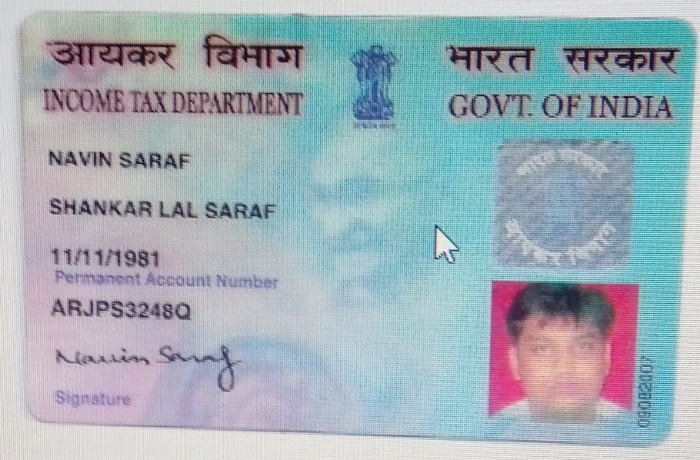

In [15]:
from PIL import Image
seed(2)
img_path = sample(remaining_pan,1)[0]
img = cv2.imread(img_path)
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Since EAST detector requires the image dimensions to be mmultiple of 32, we resize the images accordingly. It was observed that most of the images have fixed width of 700. Hence we choose 640 as our desired width as **640**. The height is calculated to resize the image with minimum possible distortion in the aspect ratio

In [18]:
h, w = img.shape[:2]
new_w = 640
new_h = round( h * new_w / (w * 32)) *32
img = cv2.resize(img, (new_w, new_h))

We need to extract the output feature map of two layers which will give us the output probability of containing text and the bounding box of the area containing the text respectively.

In [19]:
layer_names = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

Next, we will load the pre-trained EAST model. 

In [20]:
%%time
net = cv2.dnn.readNet("frozen_east_text_detection.pb")


CPU times: user 455 ms, sys: 64.5 ms, total: 519 ms
Wall time: 516 ms


Next, a blob is created from the image and a forward pass is made through the net to obtain the two output layers

In [21]:
means = tuple(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).mean(axis=(0,1)))
blob = cv2.dnn.blobFromImage(img, 1.0, (new_w, new_h), means, swapRB=True, crop=False)

In [22]:
blob.shape

(1, 3, 416, 640)

In [23]:
%%time
net.setInput(blob)
(scores, geometry) = net.forward(layer_names)

CPU times: user 5.65 s, sys: 448 ms, total: 6.1 s
Wall time: 309 ms


We will be looping over the rows and cols of score to findout the bounding boxes for the texts
details of the code is available
[here](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/). 


**I will go through the code and write a detailed guide for this part later**

In [25]:
%%time
import numpy as np
nrow, ncol = scores.shape[2:4]
rects = []
confidences = []

for y in range(0,nrow):
    score = scores[0,0,y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    for x in range(0, ncol):
        if score[x] < 0.05: 
            continue # discard regions where the probability is too low
        offset_x, offset_y = x*4.0, y * 4
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        endX = int(offset_x + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offset_y - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        rects.append((startX, startY, endX, endY))
        confidences.append(score[x])

CPU times: user 74.7 ms, sys: 11.2 ms, total: 85.9 ms
Wall time: 83.2 ms


In [26]:
rects[0]

(185, 30, 275, 61)

In [27]:
%%timeit
ax0, ax1, ax2, ax3 = np.where(scores>=0.05)
selected_geometry = geometry[ax0,:,ax2,ax3]
offset_x = ax3 * 4
offset_y = ax2 * 4
cos = np.cos(selected_geometry[:,4])
sin = np.sin(selected_geometry[:,4])
h, w = selected_geometry[:,[0,2]].sum(axis=1),  selected_geometry[:,[1,3]].sum(axis=1)
endX = (offset_x + (cos * selected_geometry[:,1]) + (sin * selected_geometry[:,2])).astype(int)
endY = (offset_y - (sin * selected_geometry[:,1]) + (cos * selected_geometry[:,2])).astype(int)
startX = (endX - w).astype(int)
startY = (endY - h).astype(int)
rects = list(zip(startX, startY, endX, endY))
confidences = scores[ax0, ax1, ax2, ax3]


819 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
rects[0]

(185, 30, 275, 61)

In [29]:
from imutils.object_detection import non_max_suppression
boxes = non_max_suppression(np.array(rects), probs=confidences)
 
# loop over the bounding boxes
img1 = img.copy()
for (startX, startY, endX, endY) in boxes:
	cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)



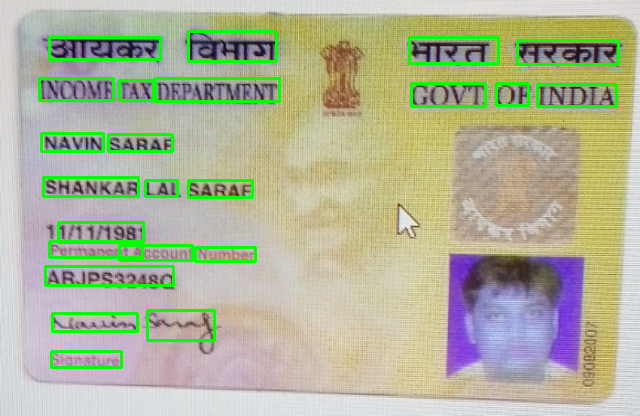

In [30]:
Image.fromarray(img)

As We can see, the 8th box contains the PAN. However, if we naively run tesseract on this, we are likely to get incorrect result. Hence, we will try to put a few filters and retry the procedure. 

In [31]:
startx, starty, endx, endy = boxes[7]
img2 = img1[starty-10:endy+10, startx-10:endx+10]


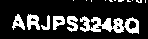

'ARJPS3248Q'

In [32]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(gray, 120,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

display(Image.fromarray(th))
pytesseract.image_to_string(th)

In this case, a simple binarization did the trick. However, this may not work for all cases. Hence, we will start building a function including the naive method and binarization. The function will be used iteratively on all images till the first one fails, and then we will proceed from there.

In [42]:
from imutils.object_detection import non_max_suppression
ptrn = re.compile(".*(?P<pan>[A-Z0]{3}[ABCFGHJLPT][A-Z0]{1}[Oo0-9]{4}[A-Z0]{1})")
layer_names = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

def extract_pan(img_path, ptrn):
    img = cv2.imread(img_path)
    if img is None:
        return -1
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    strng = [ptrn.match(i.strip()) for i in pytesseract.image_to_string(gray).split("\n") if i.strip()]
    pan_no = [i.groupdict()['pan'] for i in strng if i]
    if pan_no:
        return pan_no[0]
    h, w = img.shape[:2]
    new_w = 640
    new_h = round( h * new_w / (w * 32)) *32
    img = cv2.resize(img, (new_w, new_h))
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    means = tuple(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).mean(axis=(0,1)))
    blob = cv2.dnn.blobFromImage(img, 1.0, (new_w, new_h), means, swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)
    ax0, ax1, ax2, ax3 = np.where(scores>=0.05)
    selected_geometry = geometry[ax0,:,ax2,ax3]
    offset_x = ax3 * 4
    offset_y = ax2 * 4
    cos = np.cos(selected_geometry[:,4])
    sin = np.sin(selected_geometry[:,4])
    h, w = selected_geometry[:,[0,2]].sum(axis=1),  selected_geometry[:,[1,3]].sum(axis=1)
    endX = (offset_x + (cos * selected_geometry[:,1]) + (sin * selected_geometry[:,2])).astype(int)
    endY = (offset_y - (sin * selected_geometry[:,1]) + (cos * selected_geometry[:,2])).astype(int)
    startX = (endX - w).astype(int)
    startY = (endY - h).astype(int)
    rects = list(zip(startX, startY, endX, endY))
    confidences = scores[ax0, ax1, ax2, ax3]
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    img1 = img.copy()
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
    tmp = []
    for startx, starty, endx, endy in boxes:
        pad_x = int((endx - startx) * .1)
        pad_y = int((endy - starty) * .1)
        startx = max(0, startx-pad_x)
        starty = max(0, starty-pad_y)
        endx = min(img.shape[1], endx + pad_x)
        endy = min(img.shape[0], endy + pad_y)
        if abs(startx-endx) > abs(starty-endy):
            text = pytesseract.image_to_string(img1[starty:endy, startx:endx])
#             display(text)
            if ptrn.match(text.strip()):
                return ptrn.match(text.strip()).groupdict()['pan']
            tmp.append(img1[starty:endy, startx:endx])
        else:
            text1 = pytesseract.image_to_string(np.rot90(img1[starty:endy, startx:endx]))
            if ptrn.match(text1.strip()):
                return ptrn.match(text1.strip()).groupdict()['pan']
            text2 = pytesseract.image_to_string(np.rot90(img1[starty:endy, startx:endx], -1))
            if ptrn.match(text2.strip()):
                return ptrn.match(text2.strip()).groupdict()['pan']
            tmp.append(np.rot90(img1[starty:endy, startx:endx]))
    for img2 in tmp:
        gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray)
#         display(text)
        if ptrn.match(text.strip()):
                return ptrn.match(text.strip()).groupdict()['pan']
        th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5)
        text = pytesseract.image_to_string(th)
        if ptrn.match(text.strip()):
                return ptrn.match(text.strip()).groupdict()['pan']
    return Image.fromarray(img)
            

In [50]:
%%time
succ = []
fail = []
for pan in pan_list:
#     print(pan)
    exception_list = [
        'images/PAN/07820212887421.jpeg',  # xerox copy
        'images/PAN/07820211254038.jpeg',  # PASSPORT
    ]
    if pan in exception_list:
        continue
    if not isinstance(extract_pan(pan, ptrn), str):
        fail.append(pan)
    else:
        succ.append(pan)
    print('{} completed, {} successful'.format(len(succ)+len(fail), len(succ)), end='\r')

CPU times: user 41min 5s, sys: 23min 36s, total: 1h 4min 41s
Wall time: 1h 8min 25s


In [53]:
len(succ)

365

'INCOME 1'

'PF INDIA.'

'- CHATURVEDI'

'‘Number'

''

'PIYUSH'

''

'4 CHATURVEDI'

''

'ee.\nAAMMDCIRO3.)'

''

'PRAFUL |'

''

'v DEPARTMENT.'

''

'wnt Account !'

''

''

''

''

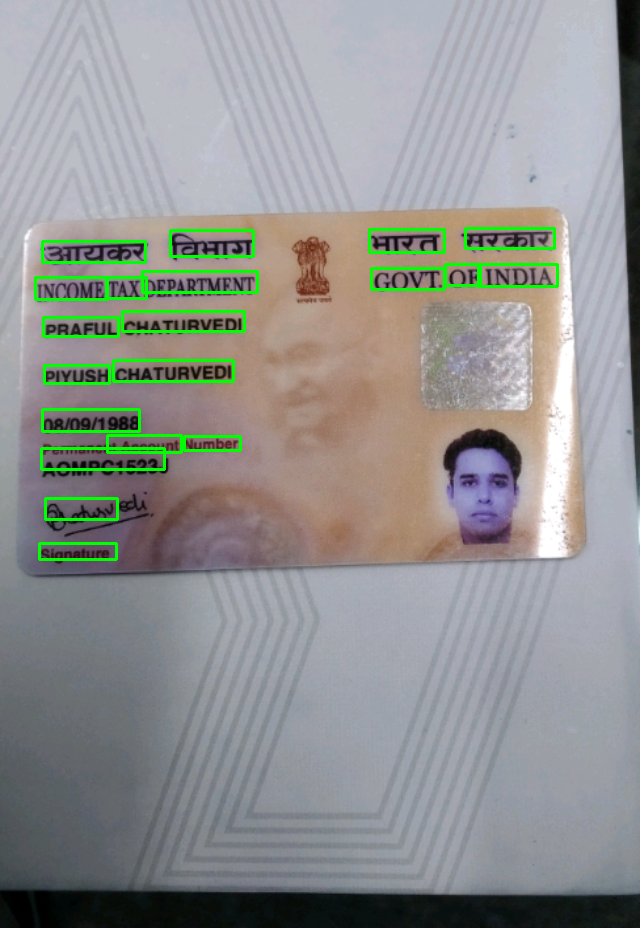

In [37]:
extract_pan(pan, ptrn)

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

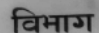

''

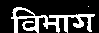

''

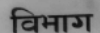

''

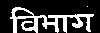

''

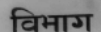

''

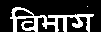

''

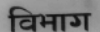

''

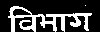

''

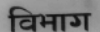

''

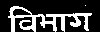

''

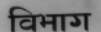

''

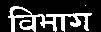

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

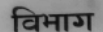

''

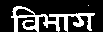

''

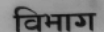

''

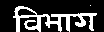

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

'ns rs 3) ee'

''

'Peres Ce'

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

'ins ars]'

''

'Peres Ce'

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

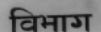

''

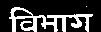

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

''

'pINDIA'

'abby F. ee'

'Pr INDIA'

'wm ANTD) Ped'

'pINDIA'

'ante) Fee'

'- INDIA'

'BiNiD) 7:'

'PF INDIA'

'om aN1D) Fe'

'PF INDIA'

'om aN1D) Fe'

'F INDIA.'

'FINDIA:'

'F INDIA'

'RINDIA:'

'FINDIA'

'FINDIA:'

'FINDIA'

'FINDIA:'

'FINDIA'

'FINDIA:'

'FINDIA'

'FINDIA:'

'FINDIA'

'FINDIA:'

''

'GOVT.'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

''

'GOVT |'

''

'GOVT.'

''

'GOVL.'

''

'GOVL.'

''

'GOVL.'

''

'GOVL.'

''

'GOVT.'

''

'GOVT.'

''

'GOVT.'

''

''

''

''

''

''

''

''

''

''

'PINDIA'

'ma ib iF: Ga'

'INDIA'

'watipi hae'

'INDIA'

'INDIA”'

'INDIA'

'Bibi P-Ge'

'pINDIA'

'Biniby he'

'- INDIA'

'mand) F: te'

'INDIA.'

'mind) F: es'

'PF INDIA.'

'RINDIA'

'PF INDIA.'

'RINDIA'

'F INDIA.'

'cman) F: es'

'F INDIA.'

'FINDIA:'

'F INDIA.'

'FINDIA:'

'PF INDIA.'

'RINDIA'

'F INDIA.'

'FINDIA:'

'PF INDIA'

'INDE we'

''

'GOVT. |'

''

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

'GOVT |'

''

'GOVT |'

''

'GOVT.'

''

'GOVT. |'

''

'GOVT. |'

''

'GOVT. |'

''

'GOVL.'

''

'GOVL.'

''

'GOVL.'

''

'GOVT.'

''

''

''

''

''

''

''

''

'PINDIA'

'INDIA”:'

'INDIA'

'BAND) F: es'

'pINDIA'

'wii} Fe'

'PINDIA'

'wii) Fe'

'Pr INDIA'

'mtNibE:%'

'- INDIA'

'TINDIA:'

'P INDIA'

'maNibie:S'

'fF INDIA.'

'RINDIA:'

'fF INDIA.'

'RINDIA:'

'FINDIA'

'omiNiD) Fe'

'FINDIA'

'omiNiD) Fe'

'PF INDIA.'

'RINDIA'

'PF INDIA'

'winters'

'INDIA.'

'mabiF:%'

'INDIA'

'tT INDIA:'

'B TAXI'

'mS'

'B TAX'

'mel'

'¥ DEPARTMENT'

'TSR ae eae'

'¥ DEPARTMENT.'

'Sena aan'

'¥ DEPARTMENT.'

'¥Y DEPARTMENT'

'¥ DEPARTMENT'

'Sena aan'

'x DEPARTMENT'

'Shae'

'¥ DEPARTMENT'

'TSR ae eae'

'¥ DEPARTMENT'

'Pena'

'¥ DEPARTMENT'

'TSR ae eae'

'¥ DEPARTMENT'

'TSR ae eae'

'x DEPARTMENT'

'Shae'

'x DEPARTMENT'

'Shae'

', DEPARTMENT'

'Shae'

'¥ DEPARTMENT'

'¥ DEPARTMENT.'

'¥ DEPARTMENT'

'¥ DEPARTMENT.'

'¥ DEPARTMENT'

'¥ DEPARTMENT.'

'¥ DEPARTMENT'

'¥ DEPARTMENT.'

'¥ DEPARTMENT'

'¥ DEPARTMENT.'

KeyboardInterrupt: 

In [39]:
img = cv2.imread(pan)
h, w = img.shape[:2]
new_w = 640
new_h = round( h * new_w / (w * 32)) *32
img = cv2.resize(img, (new_w, new_h))
net = cv2.dnn.readNet("frozen_east_text_detection.pb")
means = tuple(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).mean(axis=(0,1)))
blob = cv2.dnn.blobFromImage(img, 1.0, (new_w, new_h), means, swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layer_names)
ax0, ax1, ax2, ax3 = np.where(scores>=0.05)
selected_geometry = geometry[ax0,:,ax2,ax3]
offset_x = ax3 * 4
offset_y = ax2 * 4
cos = np.cos(selected_geometry[:,4])
sin = np.sin(selected_geometry[:,4])
h, w = selected_geometry[:,[0,2]].sum(axis=1),  selected_geometry[:,[1,3]].sum(axis=1)
endX = (offset_x + (cos * selected_geometry[:,1]) + (sin * selected_geometry[:,2])).astype(int)
endY = (offset_y - (sin * selected_geometry[:,1]) + (cos * selected_geometry[:,2])).astype(int)
startX = (endX - w).astype(int)
startY = (endY - h).astype(int)
rects = list(zip(startX, startY, endX, endY))
confidences = scores[ax0, ax1, ax2, ax3]
boxes = non_max_suppression(np.array(rects), probs=confidences)
img1 = img.copy()
for (startX, startY, endX, endY) in rects:
    cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
tmp = []
for startx, starty, endx, endy in rects:
    pad_x = int((endx - startx) * .1)
    pad_y = int((endy - starty) * .1)
    startx = max(0, startx-pad_x)
    starty = max(0, starty-pad_y)
    endx = min(img.shape[1], endx + pad_x)
    endy = min(img.shape[0], endy + pad_y)   
    if abs(startx-endx) > abs(starty-endy):
#         display(Image.fromarray(img1[starty:endy, startx:endx]))
        text = pytesseract.image_to_string(img1[starty:endy, startx:endx])
#         display(text)
        tmp.append(img1[starty:endy, startx:endx])
    else:
        text1 = pytesseract.image_to_string(np.rot90(img1[starty:endy, startx:endx]))
        text2 = pytesseract.image_to_string(np.rot90(img1[starty:endy, startx:endx], -1))   
        tmp.append(img1[starty:endy, startx:endx])
for img2 in tmp:
        gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray)
        display(Image.fromarray(gray))
        display(text)
        th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5)
        text = pytesseract.image_to_string(th)
        display(Image.fromarray(th))
        display(text)
        

In [377]:
startx, starty, endx, endy = boxes[5]
pad_x = int((endx - startx) * .05)
pad_y = int((endy - starty) * .05)
startx = max(0, startx-pad_x)
starty = max(0, starty-pad_y)
endx = min(img.shape[1], endx + pad_x)
endy = min(img.shape[0], endy + pad_y)   
img2 = img1[starty:endy, startx:endx]
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5)
display(Image.fromarray(th))
text = pytesseract.image_to_string(th)

display(text)


'CLRPM3909E'

In [425]:
for idx, (startx, starty, endx, endy) in enumerate(rects[653:714]):
    pad_x = int((endx - startx) * .1)
    pad_y = int((endy - starty) * .1)
    startx = max(0, startx-pad_x)
    starty = max(0, starty-pad_y)
    endx = min(img.shape[1], endx + pad_x)
    endy = min(img.shape[0], endy + pad_y)   
    img2 = img1[starty:endy, startx:endx]
    display(Image.fromarray(img2))
    display(confidences[idx])

0.69095886

0.99253476

0.9974891

0.9990103

0.99922335

0.9994253

0.99961746

0.9997639

0.9997106

0.9993511

0.10000536

0.9840635

0.9916825

0.9384409

0.5935326

0.25161186

0.38616613

0.80613613

0.882224

0.90599006

0.9141068

0.8874548

0.9790051

0.9989242

0.9992551

0.99909294

0.8105863

0.9992735

0.9995028

0.9995178

0.9995043

0.99952435

0.9995797

0.99957544

0.99957985

0.9995408

0.9995005

0.99940896

0.99943286

0.99927264

0.80116206

0.9986688

0.99966884

0.999718

0.99976414

0.9997899

0.9998153

0.9998048

0.99979514

0.99988174

0.9999218

0.99993896

0.9999442

0.9999473

0.99995565

0.99996066

0.99996614

0.9999689

0.9999584

0.999884

0.9993963

In [414]:

pad_x = int((endX - startx) * .05)
pad_y = int((endy - starty) * .05)
startx = max(0, startX-pad_x)
starty = max(0, starty-pad_y)
endx = min(img.shape[1], endx + pad_x)
endy = min(img.shape[0], endy + pad_y)


In [427]:
import sys
!{sys.executable} -m pip install tensorflow

Looking in indexes: http://10.10.211.49:8080/simple/
     |████████████████████████████████| 86.3MB 25.7MB/s eta 0:00:01     |████████████████████▊           | 56.0MB 3.7MB/s eta 0:00:09
     |████████████████████████████████| 2.4MB 31.0MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 33.7MB/s eta 0:00:01
  ERROR: Could not find a version that satisfies the requirement tensorflow-estimator<2.1.0,>=2.0.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for tensorflow-estimator<2.1.0,>=2.0.0 (from tensorflow)


In [431]:
boxes = np.array(rects)

In [438]:
boxes = boxes.astype(np.float64)
boxes 

array([[466., 226., 561., 249.],
       [468., 227., 559., 248.],
       [469., 228., 556., 249.],
       ...,
       [ 42., 545., 110., 561.],
       [ 41., 545., 110., 562.],
       [ 39., 544., 111., 561.]])

In [439]:
x1 = boxes[:, 0]
y1 = boxes[:, 1]
x2 = boxes[:, 2]
y2 = boxes[:, 3]
area = (x2 - x1 + 1) * (y2 - y1 + 1)

In [437]:
boxes[:0]

array([], shape=(0, 4), dtype=int64)